In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import time
from qiskit.providers.aer import QasmSimulator
import numpy as np
from qiskit_experiments.library import randomized_benchmarking as rb
#from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
from qiskit_experiments.library import StandardRB, InterleavedRB
import qiskit.circuit.library as circuits
import qiskit.circuit.library
from qiskit.circuit import Delay, Instruction
from qiskit.circuit.library.standard_gates import XGate, SXGate, IGate, CCXGate, SGate
from datetime import datetime


# For simulation
from qiskit.providers.aer import AerSimulator

In [7]:
from qiskit import IBMQ
#IBMQ.save_account('befca44219528a564b7f4d3f53707de8985c22fb7b8c969ef2728c830de7c612716e76f41fbc0a52d65f63e71a3a2437948befd3042b1ffab4ced07d573192f1')
IBMQ.load_account()
IBMQ.providers()

ibmqfactory.load_account:WARNING:2022-06-03 17:31:13,811: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='spring-22-17')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='spring-22-17-2')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='internal', project='reservations')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='squirl')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-4', project='recdZ7NwFc2tUZtMH')>]

In [9]:
provider=IBMQ.providers()[3]
#provider = IBMQ.get_provider(hub='ibm-q-community', group='qamp', project='spring-22-17')
#backend=provider.backend.ibmq_lima
backend = provider.get_backend('ibmq_toronto')

# get the basic feautures including qubit number of the backend.
config = backend.configuration()
backend_job_limit=backend.job_limit()

print("{0} is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}.{6} are the list of connected qubits."
      "{7} can handle maximum {8} circuits(experiments) per job."
      "Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is {9}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map,
               config.backend_name,
               config.max_experiments,
               backend_job_limit.maximum_jobs))

ibmq_toronto is on version 1.7.4. It has 27 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]] are the list of connected qubits.ibmq_toronto can handle maximum 900 circuits(experiments) per job.Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is None.


# toronto_q1,4
- CLE(0.006865)~<CX(0.007519)<2qDelay(0.009008)
- CLE(0.006284)<CX(0.00968)~<2qDelay(0.01055)

ibmq_toronto
toronto_q1,4
reported CXerror at 2022-05-30 17:17:46.687980 is 0.008380023964538408
2022-05-30 17:17:48.423449


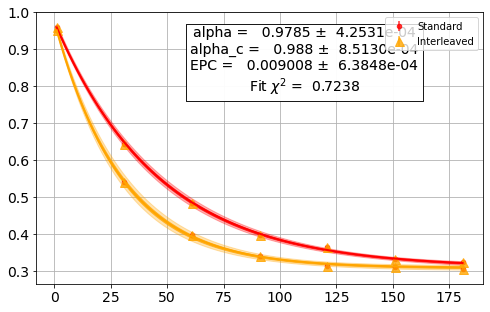

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6651070633266088, 0.9785389444642151, 0.9879895624353834, 0.3074898043345054]
- χ²: 0.7237546536911141
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9785+/-0.0004
- χ²: 0.7237546536911141
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9880+/-0.0009
- χ²: 0.7237546536911141
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0090+/-0.0006
- χ²: 0.7237546536911141
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q4']
- verified: False
0.008380023964538408


In [4]:
#first trial
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,4]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(1,4))
print(backend)
print('toronto_q1,4_2qDelay')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(1,4))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[1,4], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print(backend.properties().gate_error('cx',(1,4)))

ibmq_toronto
CXGate
2022-05-30 17:37:40.404010


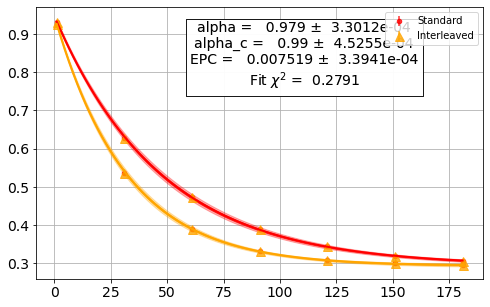

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6526212475660949, 0.9789910515018739, 0.989974099262352, 0.29326623586554124]
- χ²: 0.2791048378833971
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.97899+/-0.00033
- χ²: 0.2791048378833971
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9900+/-0.0005
- χ²: 0.2791048378833971
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.00752+/-0.00034
- χ²: 0.2791048378833971
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q4']
- verified: False


In [5]:
#first trial
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,4]
print(backend)
print('CXGate')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

### Second trial : EPC_CX(1,4)=0.00968 
- length=(1, 400, 40)
- result deleted by mistake

ibmq_toronto
toronto_q1,4
reported CXerror at 2022-05-30 17:44:46.451381 is 0.008380023964538408
2022-05-30 17:44:46.451381


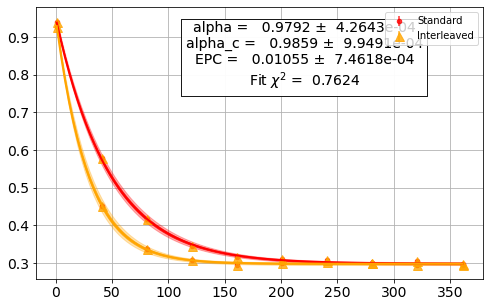

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6532133969111572, 0.9791873674471748, 0.9859355221461448, 0.2983965349437427]
- χ²: 0.7623916107637214
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9792+/-0.0004
- χ²: 0.7623916107637214
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9859+/-0.0010
- χ²: 0.7623916107637214
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0105+/-0.0007
- χ²: 0.7623916107637214
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q4']
- verified: False
0.008380023964538408


In [6]:
#Second trial
lengths = np.arange(1, 400, 40)
num_samples = 10
seed = 1010
qubits = [1,4]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(1,4))
print(backend)
print('toronto_q1,4')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(1,4))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[1,4], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print(backend.properties().gate_error('cx',(1,4)))

In [4]:
# first set of exp
date= datetime.today()
qubit='toronto_q1q4'
toronto_q1q4=RBUtils.coherence_limit_error(2, 
backend.properties().gate_length('cx',(1,4)),
 t1s=[backend.properties().t1(1),backend.properties().t1(4)], 
 t2s=[backend.properties().t1(1),backend.properties().t1(4)])
print(f'{qubit} CLE is {toronto_q1q4} on {date}')

toronto_q1q4 CLE is 0.006865997692740234 on 2022-05-30 18:11:52.897990


In [6]:
# second set of exp
date= datetime.today()
qubit='toronto_q1q4'
toronto_q1q4=RBUtils.coherence_limit_error(2, 
backend.properties().gate_length('cx',(1,4)),
 t1s=[backend.properties().t1(1),backend.properties().t1(4)], 
 t2s=[backend.properties().t1(1),backend.properties().t1(4)])
print(f'{qubit} CLE is {toronto_q1q4} on {date}')

toronto_q1q4 CLE is 0.006284005975365315 on 2022-05-30 19:19:34.543993


# toronto_q8,11


### CLE(0.003728)<CX(0.0088)~<2qDelay(0.00968)

In [5]:
date= datetime.today()
qubit='toronto_q8q11'
toronto_q8q11=RBUtils.coherence_limit_error(2, 
backend.properties().gate_length('cx',(8,11)),
 t1s=[backend.properties().t1(8),backend.properties().t1(11)], 
 t2s=[backend.properties().t1(8),backend.properties().t1(11)])
print(f'{qubit} CLE is {toronto_q8q11} on {date}')

toronto_q8q11 CLE is 0.0037280722255344403 on 2022-05-30 19:17:20.433949


ibmq_toronto
toronto_q8q11_2qDelay
reported CXerror at 2022-05-30 18:14:32.063892 is 0.007130278634169179
2022-05-30 18:14:33.564008


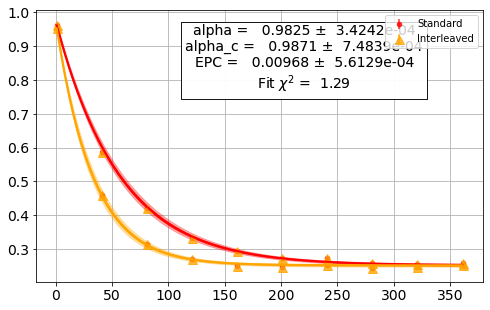

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.723184011921739, 0.9825010398960835, 0.98709305870641, 0.25135292884465515]
- χ²: 1.2900020576264115
- quality: good
- extra: <4 items>
- device_components: ['Q8', 'Q11']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.98250+/-0.00034
- χ²: 1.2900020576264115
- quality: good
- extra: <1 items>
- device_components: ['Q8', 'Q11']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9871+/-0.0007
- χ²: 1.2900020576264115
- quality: good
- extra: <1 items>
- device_components: ['Q8', 'Q11']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0097+/-0.0006
- χ²: 1.2900020576264115
- quality: good
- extra: <3 items>
- device_components: ['Q8', 'Q11']
- verified: False
CXerror rate after experiment=
0.007130278634169179


In [4]:
lengths = np.arange(1, 400, 40)
num_samples = 10
seed = 1010
qubits = [8,11]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(8,11))
print(backend)
print('toronto_q8q11_2qDelay')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(8,11))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[8,11], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print('CXerror rate after experiment=')
print(backend.properties().gate_error('cx',(8,11)))

ibmq_toronto
CXGate_q8q11
2022-05-30 18:59:29.419253


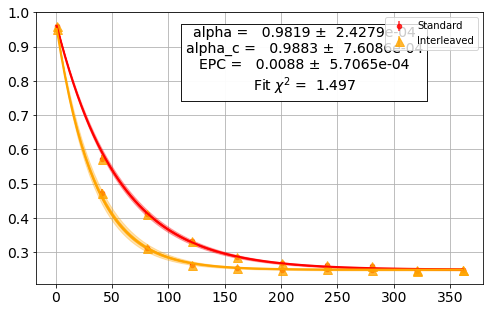

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7245423333862291, 0.9819404366302619, 0.988266804470127, 0.24856926651927652]
- χ²: 1.4965321695578953
- quality: good
- extra: <4 items>
- device_components: ['Q8', 'Q11']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.98194+/-0.00024
- χ²: 1.4965321695578953
- quality: good
- extra: <1 items>
- device_components: ['Q8', 'Q11']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9883+/-0.0008
- χ²: 1.4965321695578953
- quality: good
- extra: <1 items>
- device_components: ['Q8', 'Q11']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0088+/-0.0006
- χ²: 1.4965321695578953
- quality: good
- extra: <3 items>
- device_components: ['Q8', 'Q11']
- verified: False


In [6]:
lengths = np.arange(1, 400, 40)
num_samples = 10
seed = 1010
qubits = [8,11]
print(backend)
print('CXGate_q8q11')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# toronto_q6,7
CLE(0.00235)<CX(0.006443)~2qDelay(0.0067)

In [4]:
date= datetime.today()
qubit='toronto_q6q7'
toronto_q6q7=RBUtils.coherence_limit_error(2, 
backend.properties().gate_length('cx',(6,7)),
 t1s=[backend.properties().t1(6),backend.properties().t1(7)], 
 t2s=[backend.properties().t1(6),backend.properties().t1(7)])
print(f'{qubit} CLE is {toronto_q6q7} on {date}')

toronto_q6q7 CLE is 0.0023526854254789955 on 2022-05-30 23:05:21.060038


ibmq_toronto
toronto_q6q7_2qDelay
reported CXerror at 2022-05-30 20:26:17.107408 is 0.006889160390485122
2022-05-30 20:26:17.107408


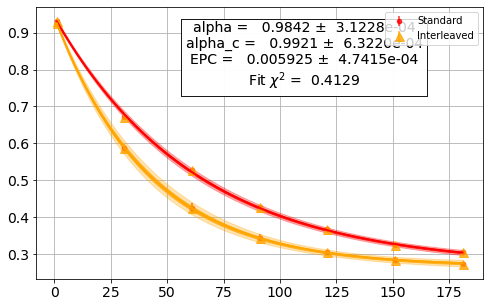

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6749998214048641, 0.984207148314238, 0.9920995189787869, 0.26640690206545725]
- χ²: 0.4128735308823385
- quality: good
- extra: <4 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.98421+/-0.00031
- χ²: 0.4128735308823385
- quality: good
- extra: <1 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9921+/-0.0006
- χ²: 0.4128735308823385
- quality: good
- extra: <1 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0059+/-0.0005
- χ²: 0.4128735308823385
- quality: good
- extra: <3 items>
- device_components: ['Q6', 'Q7']
- verified: False
CXerror rate after experiment=
0.006889160390485122


In [7]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [6,7]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(6,7))
print(backend)
print('toronto_q6q7_2qDelay')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(6,7))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[6,7], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print('CXerror rate after experiment=')
print(backend.properties().gate_error('cx',(6,7)))

ibmq_toronto
toronto_q6q7_2qDelay
reported CXerror at 2022-05-30 20:00:04.651191 is 0.006889160390485122
2022-05-30 20:00:06.084984


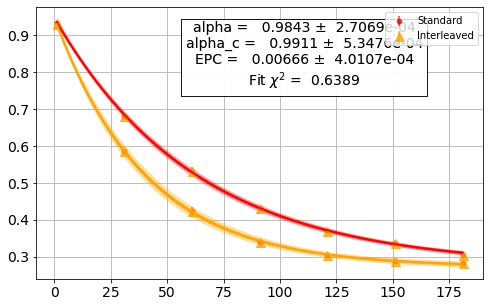

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6732974702554702, 0.9842575130640607, 0.9911194386353355, 0.2729904216511662]
- χ²: 0.6389260983228288
- quality: good
- extra: <4 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.98426+/-0.00027
- χ²: 0.6389260983228288
- quality: good
- extra: <1 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9911+/-0.0005
- χ²: 0.6389260983228288
- quality: good
- extra: <1 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0067+/-0.0004
- χ²: 0.6389260983228288
- quality: good
- extra: <3 items>
- device_components: ['Q6', 'Q7']
- verified: False
CXerror rate after experiment=
0.006889160390485122


In [5]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [6,7]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(6,7))
print(backend)
print('toronto_q6q7_2qDelay')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(6,7))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[6,7], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print('CXerror rate after experiment=')
print(backend.properties().gate_error('cx',(6,7)))

ibmq_toronto
CXGate_q6q7
2022-05-30 20:18:06.072042


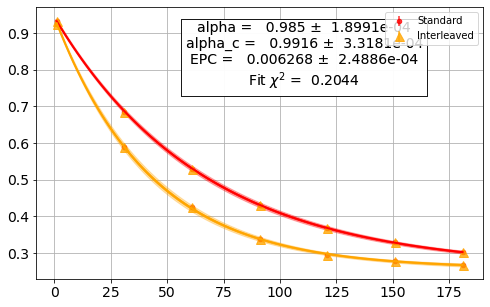

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.684943906067501, 0.9850382615376955, 0.9916424429242464, 0.2578996532382229]
- χ²: 0.20435299090932885
- quality: good
- extra: <4 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.98504+/-0.00019
- χ²: 0.20435299090932885
- quality: good
- extra: <1 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.99164+/-0.00033
- χ²: 0.20435299090932885
- quality: good
- extra: <1 items>
- device_components: ['Q6', 'Q7']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.00627+/-0.00025
- χ²: 0.20435299090932885
- quality: good
- extra: <3 items>
- device_components: ['Q6', 'Q7']
- verified: False


In [6]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [6,7]
print(backend)
print('CXGate_q6q7')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# tornoto_q16q19

In [5]:
date=datetime.today()
CLE=RBUtils.coherence_limit(nQ=2, 
T1_list=[backend.properties().t1(16),backend.properties().t1(19)],
T2_list=[backend.properties().t2(16),backend.properties().t2(19)], 
gatelen=backend.properties().gate_length('cx',(16,19)))
print(f"CLE is {CLE} at {date}")

CLE is 0.0035389319787184625 at 2022-06-03 17:01:45.947660


ibmq_toronto
toronto_q16q19_2qDelay
reported CXerror at 2022-06-03 17:02:35.397506 is 0.008561104740084646
2022-06-03 17:02:35.398495


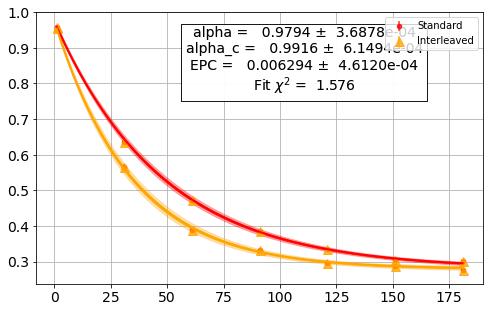

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6948337315894071, 0.9793691032182212, 0.9916075023827878, 0.2791525964340334]
- χ²: 1.5763649428116298
- quality: good
- extra: <4 items>
- device_components: ['Q16', 'Q19']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9794+/-0.0004
- χ²: 1.5763649428116298
- quality: good
- extra: <1 items>
- device_components: ['Q16', 'Q19']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9916+/-0.0006
- χ²: 1.5763649428116298
- quality: good
- extra: <1 items>
- device_components: ['Q16', 'Q19']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0063+/-0.0005
- χ²: 1.5763649428116298
- quality: good
- extra: <3 items>
- device_components: ['Q16', 'Q19']
- verified: False
CXerror rate after experiment=
0.008561104740084646


In [6]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [16,19]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(16,19))
print(backend)
print('toronto_q16q19_2qDelay')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(16,19))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[16,19], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print('CXerror rate after experiment=')
print(backend.properties().gate_error('cx',(16,19)))

ibmq_toronto
CXGate_q16q19
2022-06-03 17:31:58.370355


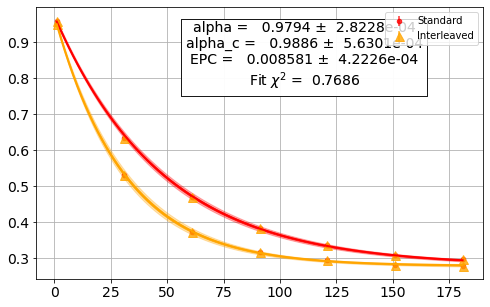

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6938058989903397, 0.9793522935589092, 0.9885584311336925, 0.2780475843309655]
- χ²: 0.7685671987503264
- quality: good
- extra: <4 items>
- device_components: ['Q16', 'Q19']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.97935+/-0.00028
- χ²: 0.7685671987503264
- quality: good
- extra: <1 items>
- device_components: ['Q16', 'Q19']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9886+/-0.0006
- χ²: 0.7685671987503264
- quality: good
- extra: <1 items>
- device_components: ['Q16', 'Q19']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0086+/-0.0004
- χ²: 0.7685671987503264
- quality: good
- extra: <3 items>
- device_components: ['Q16', 'Q19']
- verified: False


In [10]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [16,19]
print(backend)
print('CXGate_q16q19')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)